# 🧬 シングルセル解析
このノートブックでは、`scanpy` を用いて、ヒト末梢血単核細胞（PBMC）から得られた scRNA-seq データ（PBMC3K）を処理し、クラスタリングと PanglaoDB マーカーによる細胞型推定を行う。

---
## 📚 手順概要

1. データ読み込み（PBMC3k）
2. 品質管理（QC）と前処理
3. 正規化とスケーリング
4. 次元削減とクラスタリング
5. クラスタごとのマーカー遺伝子抽出
6. PanglaoDBのマーカー遺伝子を読み込み
7. クラスタごとに細胞型を推定（PanglaoDBと照合）
8. 細胞型ラベルを各細胞に割り当てる
9. 細胞型ラベルでUMAPを描画

## 🚀 ライブラリのインストール（初回のみ）

In [1]:
!pip install scanpy
!pip install igraph
!pip install leidenalg

     |████████████████████████████████| 2.1 MB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 90 kB 18.1 MB/s eta 0:00:01
     |████████████████████████████████| 56 kB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.6 MB 28.4 MB/s eta 0:00:01
     |████████████████████████████████| 66 kB 17.7 MB/s eta 0:00:01
     |████████████████████████████████| 294 kB 27.8 MB/s eta 0:00:01
     |████████████████████████████████| 128 kB 32.5 MB/s eta 0:00:01
     |████████████████████████████████| 39.4 MB 32.3 MB/s eta 0:00:01     |████████▍                       | 10.3 MB 20.7 MB/s eta 0:00:02
     |████████████████████████████████| 21.2 MB 20.9 MB/s eta 0:00:01
     |████████████████████████████████| 7.9 MB 33.3 MB/s eta 0:00:01
     |████████████████████████████████| 2.6 MB 25.6 MB/s eta 0:00:01
     |████████████████████████████████| 10.1 MB 27.2 MB/s eta 0:00:01
     |████████████████████████████████| 11.6 MB 21.9 MB/s eta 0:00:01
     |████████████████████████████

関連ライブラリを読み込む

In [2]:
import scanpy as sc
import pandas as pd

## 📥 1. データ読み込み（PBMC3k）

In [3]:
adata = sc.datasets.pbmc3k()

In [4]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

2700細胞 x 32738遺伝子のAnnDataが作成されました。

各細胞の全リードに対して占める割合が最も高い遺伝子を表示します。

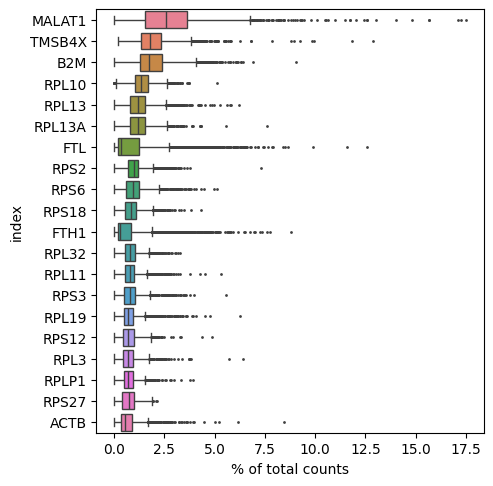

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20, )

ここからどんどんフィルタリングします。

## 🔬 2. 品質管理（QC）と前処理
発現遺伝子数が200未満の細胞、発現細胞数が3未満の遺伝子をフィルタします。

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

発現細胞数が3未満の19,024遺伝子がフィルタされ、2700細胞 x 13714遺伝子のAnnDataになりました。

次に、品質評価に重要なミトコンドリア遺伝子の発現量を計測します。 ミトコンドリアの発現割合が高い細胞は死細胞とみなされます。 (Lun, McCarthy & Marioni, 2017)

In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

異常な細胞（ミトコンドリア高い、遺伝子数多すぎ）を除去）
ミトコンドリア由来の遺伝子が多すぎる細胞(5%以上)、またはtotal countsの値が多すぎる細胞(2500以上)を削除します。

In [9]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

2638細胞 x 13714遺伝子のAnnDataになりました。

## 🧪 3. 正規化とスケーリング
各細胞の総カウントをそろえて10000に正規化

In [10]:
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_normalization.py:269: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


対数変換（log1p = log(x+1)）

In [11]:
sc.pp.log1p(adata)

変動の大きい遺伝子（高変動遺伝子）の選択

In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]

スケーリング（平均0・分散1に標準化）

In [13]:
sc.pp.scale(adata, max_value=10)

/usr/local/lib/python3.11/dist-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/usr/lib/python3.11/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


## 🌐 4. 次元削減とクラスタリング
主成分分析（PCA）

In [14]:
sc.tl.pca(adata)

近傍グラフの計算を行います。これは細胞間の距離（類似性や関連性）を数値化し、細胞間の関係をグラフ構造で表現することを目的としています。

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

UMAPによる2次元可視化

In [16]:
sc.tl.umap(adata)

近傍グラフのクラスタリングを行います。

In [17]:
sc.tl.leiden(adata, resolution=0.5)  # louvainでも可

/tmp/ipython-input-17-3820399377.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5)  # louvainでも可


クラスタごとに色を付けてUMAPを表示

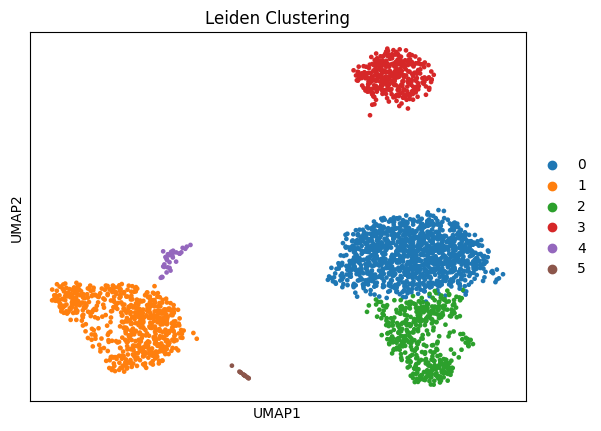

In [18]:
sc.pl.umap(adata, color='leiden', title='Leiden Clustering')

## 🧬 5. クラスタごとのマーカー遺伝子抽出

In [19]:
sc.tl.rank_genes_groups(adata, groupby='leiden', method='wilcoxon')

/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.11/dist-packages/scanpy/tools/_rank_genes_groups.py:482: 

各クラスタのマーカー遺伝子（上位20）を可視化

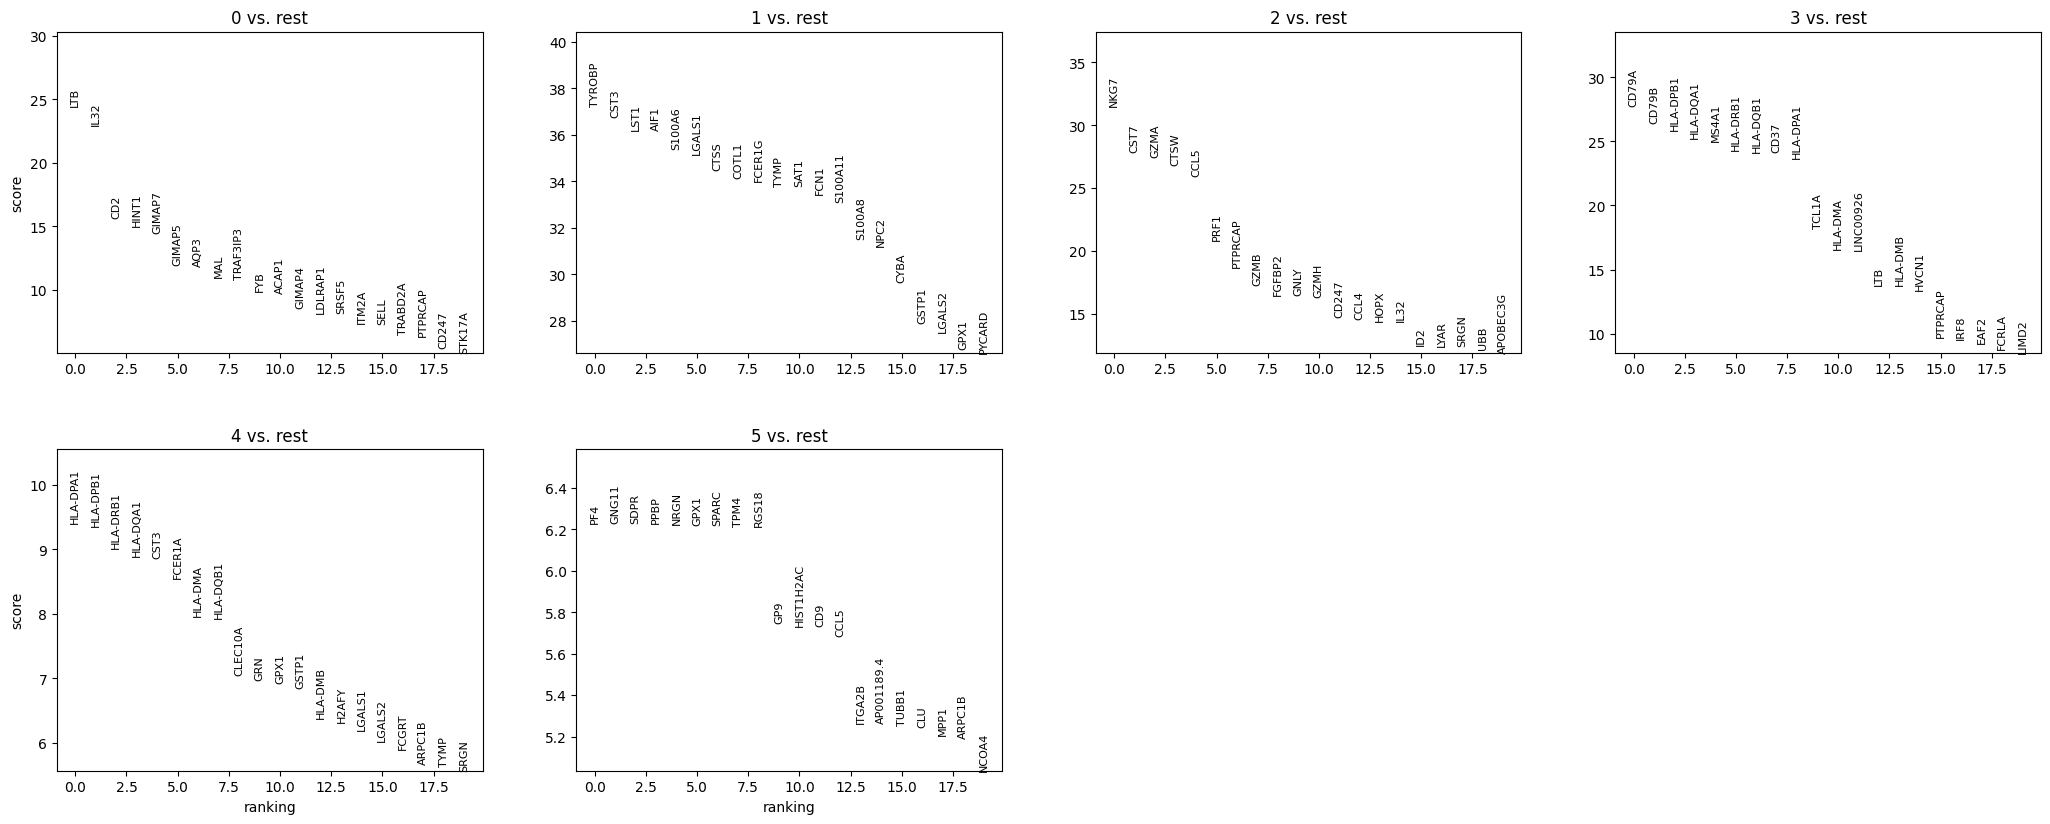

In [20]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## 📥 6. PanglaoDBのマーカー遺伝子を読み込み

In [21]:
import pandas as pd
panglao = pd.read_csv("https://github.com/iwata97/bioinfo/raw/refs/heads/main/PanglaoDB_markers_27_Mar_2020.tsv", sep="\t")

ヒトのマーカーのみ抽出

In [23]:
panglao = panglao[panglao["species"] == "Hs"]
panglao.head()

species official gene symbol     cell type             nicknames  \
22      Hs                CTRB2  Acinar cells                   NaN   
26      Hs                REG1A  Acinar cells        PSPS|PSPS1|REG   
31      Hs             SERPINA3  Acinar cells                  AACT   
33      Hs                REG1B  Acinar cells  PSPS2|REGH|REGI-BETA   
37      Hs             C15ORF48  Acinar cells       NMES1|MIR147BHG   

    ubiquitousness index                  product description  \
22                 0.001                  chymotrypsinogen B2   
26                 0.005   regenerating family member 1 alpha   
31                 0.000             serpin family A member 3   
33                 0.002    regenerating family member 1 beta   
37                 0.018  chromosome 15 open reading frame 48   

              gene type  canonical marker germ layer     organ  \
22  protein-coding gene               1.0   Endoderm  Pancreas   
26  protein-coding gene               1.0   Endoderm  Pancreas   
31  protein-coding gene               1.0   Endoderm  Pancreas   
33  protein-coding gene               1.0   Endoderm  Pancreas   
37  protein-coding gene               1.0   Endoderm  Pancreas   

    sensitivity_human  sensitivity_mouse  specificity_human  specificity_mouse  
22           0.916667                0.0           0.001258                0.0  
26           1.000000                0.0           0.027359                0.0  
31           0.000000                0.0           0.000314                0.0  
33           0.916667                0.0           0.011006                0.0  
37           1.000000                0.0           0.109119                0.0

## 🔍 7. クラスタごとに細胞型を推定（PanglaoDBと照合）

In [24]:
cluster_to_celltype = {}

for cluster in adata.obs['leiden'].cat.categories:
    # 各クラスタの上位20マーカー遺伝子を取得
    genes = adata.uns['rank_genes_groups']['names'][cluster][:20]
    # PanglaoDBで一致する細胞型を検索
    matched = panglao[panglao['official gene symbol'].isin(genes)]
    if not matched.empty:
        predicted_type = matched['cell type'].value_counts().idxmax()
    else:
        predicted_type = 'Unknown'
    cluster_to_celltype[cluster] = predicted_type

結果表示

In [25]:
cluster_to_celltype

{'0': 'Decidual cells',
 '1': 'Monocytes',
 '2': 'NK cells',
 '3': 'Dendritic cells',
 '4': 'Dendritic cells',
 '5': 'Unknown'}

## 🏷 8. 細胞型ラベルを各細胞に割り当てる

In [26]:
adata.obs['celltype'] = adata.obs['leiden'].map(cluster_to_celltype)

## 🎨 9. 細胞型ラベルでUMAPを描画

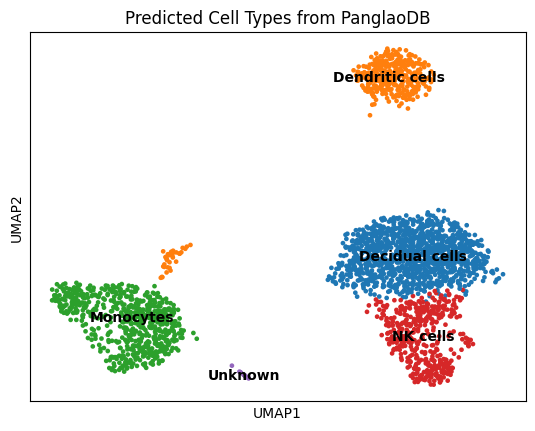

In [27]:
sc.pl.umap(adata, color='celltype', legend_loc='on data', title='Predicted Cell Types from PanglaoDB')

参考ページ
https://singlecellanalysistutorial.readthedocs.io/en/latest/notebooks/Scanpy_PBMC.html?utm_source=chatgpt.com
https://qiita.com/nikera/items/45cc4d6491182d1e0aab